In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# raw_df = pd.read_csv('/Users/yang/Documents/Wilbrecht_Lab/data/processed_tracks/RRM026/Day151/RRM026_Day151_R1_tracks_processed.csv')
raw_df = pd.read_csv('/Users/yang/Documents/Wilbrecht_Lab/data/processed_tracks/combined_df.csv')
raw_df.head()

,Head x,Head y,Neck x,Neck y,Torso x,Torso y,Tailhead x,Tailhead y,warped Head x,warped Head y,...,lapIndex,trial,decision,Head_vx,Head_vy,Head_v,angular_velocity,dPhi,animal,session
0,188.623566,28.475878,191.675903,23.529375,195.564896,11.922485,199.491653,6.846012,579.176095,299.356675,...,0,4,NaN,33.297947,-492.902488,494.025926,-8.542783,0.007309,RRM028,Day141
1,188.060455,35.737679,189.072708,28.708460,192.960205,18.967358,196.653687,7.442016,580.286027,282.926592,...,0,4,NaN,29.372719,-487.785702,488.669262,-5.358881,0.006488,RRM028,Day141
2,187.637146,43.289207,188.460831,36.384815,192.207230,24.570004,195.903427,12.627603,581.134276,266.837628,...,0,4,NaN,26.170808,-479.931514,480.644535,-0.888360,0.014482,RRM028,Day141
3,187.621353,48.790691,188.307617,43.796303,191.519562,32.192448,195.331573,20.492044,582.030747,250.931157,...,0,4,NaN,44.096649,-493.561166,495.527133,1.670589,0.045977,RRM028,Day141
4,187.166351,56.842167,187.897903,51.815838,191.288147,39.605297,195.342529,27.651142,584.074053,233.933550,...,0,4,NaN,77.330604,-524.327621,529.999506,2.489680,0.025462,RRM028,Day141


# Data Cleaning

### clean out long trials

In [3]:
# compare the sleap decision and bonsai decision
def data_cleaning(trial_df):
    sleap_decision = trial_df['decision'].dropna().iloc[0] if not trial_df['decision'].dropna().empty else np.nan
    bonsai_decision = trial_df['label'].dropna().iloc[-1] if not trial_df['label'].dropna().empty else np.nan
    length = len(trial_df['decision'].dropna())
    trial_length = len(trial_df)
    
    # Return None if the sleap_decision ends with 'T_Entry'
    if sleap_decision == 'T_Entry' and length > 1 and trial_length < 500:
        return trial_df
    else:
        return None

def get_decision_info(trial_df):
    sleap_decision = set(trial_df['decision'].dropna()) if not trial_df['decision'].dropna().empty else np.nan
    bonsai_decision = trial_df['label'].dropna().iloc[-1] if not trial_df['label'].dropna().empty else np.nan
    length = len(trial_df['decision'].dropna())
    trial_length = len(trial_df)
    restaurant = trial_df['restaurant'].iloc[0]
    
    return pd.Series({
        'sleap_decision': sleap_decision,
        'bonsai_decision': bonsai_decision,
        'length': length,
        'trial_length': trial_length,
        'restaurant': restaurant
    })

trial_decision = raw_df.groupby(['animal', 'session', 'trial'], group_keys=False).apply(get_decision_info)
print(f"bonsai decision stats:\n{trial_decision['bonsai_decision'].value_counts()}")
print(f"sleap decision stats:\n{trial_decision['sleap_decision'].value_counts()}")
print(f"trial length stats:\n{trial_decision['trial_length'].describe([.9, .95, .98, .99])}")

bonsai decision stats:
ACC        5070
quit       4625
REJ        2772
T_Entry      25
0tone         1
80tone        1
Name: bonsai_decision, dtype: int64
sleap decision stats:
{ACC, T_Entry}          5020
{T_Entry, REJ}          4570
{quit, ACC, T_Entry}    2855
{T_Entry}                 46
{REJ}                      1
{ACC, quit}                1
Name: sleap_decision, dtype: int64
trial length stats:
count    12494.000000
mean       138.196814
std        413.578530
min         25.000000
50%         51.000000
90%        211.000000
95%        442.350000
98%        981.560000
99%       1705.630000
max      12250.000000
Name: trial_length, dtype: float64


In [4]:
filtered_df = raw_df.groupby(['animal', 'session', 'trial'], group_keys=False).apply(data_cleaning).reset_index(drop=True)
filtered_decision = filtered_df.groupby(['animal', 'session', 'trial'], group_keys=False).apply(get_decision_info)
print(filtered_decision['sleap_decision'].value_counts())
print(filtered_decision['trial_length'].describe([.9, .95, .98, .99]))

{ACC, T_Entry}          5019
{T_Entry, REJ}          4405
{quit, ACC, T_Entry}    2468
Name: sleap_decision, dtype: int64
count    11892.000000
mean        77.631517
std         71.561793
min         25.000000
50%         50.000000
90%        160.000000
95%        227.450000
98%        348.000000
99%        411.000000
max        496.000000
Name: trial_length, dtype: float64


In [5]:
from scipy.stats import linregress

def calculate_straight_walking_features(segment):
    if len(segment) < 2:
        return np.nan, np.nan
    straight_walking_speed = segment['Head_v'].mean()
    x_coords = segment['warped Head x'].values
    y_coords = segment['warped Head y'].values
    if len(x_coords) < 2:
        return straight_walking_speed, np.nan
    slope, _, _, _, _ = linregress(y_coords, x_coords) # Switch x and y
    return straight_walking_speed, slope

def get_post_dec_features(post_decision_segment):
    average_x = post_decision_segment['warped Head x'].mean()
    average_y = post_decision_segment['warped Head y'].mean()
    
    return average_x, average_y

def get_features_per_trial(trial_df, frames_preserved=32):
    trial_df = trial_df.reset_index(drop=True)
    sleap_decision = trial_df['decision'].dropna().iloc[-1] if not trial_df['decision'].dropna().empty else np.nan
    bonsai_decision = trial_df['label'].dropna().iloc[-1] if not trial_df['label'].dropna().empty else np.nan
    animal = trial_df['animal'].iloc[0]
    session = trial_df['session'].iloc[0]
    trial = trial_df['trial'].iloc[0]
    restaurant = trial_df['restaurant'].iloc[0]
    trial_length = len(trial_df)
    
    standard_length_section = trial_df.head(frames_preserved)
    coords = trial_df[['warped Head x', 'warped Head y']].head(frames_preserved).values
    if len(coords) < frames_preserved:
        coords = np.pad(coords, ((0, frames_preserved - len(coords)), (0, 0)), 'edge')
    coords = coords.flatten()
    coords_dict = {f'x{i // 2 + 1}' if i % 2 == 0 else f'y{i // 2 + 1}': coords[i] for i in range(len(coords))}
    
    # Check for short trial and forward fill them
    is_short_trial = trial_length < frames_preserved
    coords_dict = {key: pd.Series(value).ffill().iloc[-1] for key, value in coords_dict.items()}

    # Identify each segments
    t_entry_idx = trial_df[trial_df['decision'] == 'T_Entry'].index[0]
    decision_idx = trial_df[(trial_df['decision'] == 'ACC') | (trial_df['decision'] == 'REJ')].index[0]
    straight_walking_segment = trial_df.iloc[:t_entry_idx+1]
    turning_segment = trial_df.iloc[t_entry_idx:decision_idx+1]
    # VTE_segment = trial_df.iloc[:decision_idx+1]
    
    straight_walking_speed, straight_walking_slope = calculate_straight_walking_features(straight_walking_segment)
    average_angular_velocity = turning_segment['angular_velocity'].mean()
    vte = straight_walking_segment['dPhi'].sum()
    hallt_bin = trial_df.loc[decision_idx, 'rel_time'] - trial_df.loc[0, 'rel_time']
    
    if 'T_Entry' in standard_length_section['decision'].values:
        average_x = standard_length_section.iloc[t_entry_idx:]['warped Head x'].mean()
        average_y = standard_length_section.iloc[t_entry_idx:]['warped Head y'].mean()
    else:
        average_x = standard_length_section['warped Head x'].iloc[-1]
        average_y = standard_length_section['warped Head y'].iloc[-1]

    t_entry_time = trial_df.loc[t_entry_idx, 'rel_time']
    result = pd.Series({
        **coords_dict,
        'sleap_decision': sleap_decision,
        'bonsai_decision': bonsai_decision,
        'animal': animal,
        'session': session,
        'trial': trial,
        'restaurant': restaurant,
        'trial_length': trial_length,
        'straight_walking_speed': straight_walking_speed,
        'straight_walking_slope': straight_walking_slope,
        'average_angular_velocity': average_angular_velocity,
        'VTE': vte,
        'hallt_bin': hallt_bin,
        'average_x': average_x,
        'average_y': average_y,
        'is_short_trial': is_short_trial,
        't_entry_time': t_entry_time 
    })
    
    return result

trial_df = filtered_df.groupby(['animal', 'session', 'trial']).apply(get_features_per_trial).reset_index(drop=True)
# trial_df = trial_df.dropna().reset_index(drop=True)
trial_df.shape

(11892, 80)

In [6]:
#plt.hist(trial_df['straight_walking_time'], range=(0.2, 1))

# save trial_df

In [7]:
# trial_df.to_csv('/Users/yang/Documents/Wilbrecht_Lab/data/processed_tracks/trial_df.csv', index=False)

In [8]:
trial_df.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,trial_length,straight_walking_speed,straight_walking_slope,average_angular_velocity,VTE,hallt_bin,average_x,average_y,is_short_trial,t_entry_time
0,587.957461,281.176387,589.517666,248.716145,592.580403,216.625293,597.009477,184.944805,601.021736,154.388021,...,37,914.176977,-0.126949,4.314413,0.255453,0.333363,696.739025,26.542259,False,0.222477
1,599.755946,334.390053,602.276490,318.047040,606.543600,301.223582,607.974361,284.078123,606.086978,266.570073,...,48,551.516718,-0.049107,0.789964,0.775902,0.966490,635.079203,64.167699,False,0.422720
2,598.564221,308.496782,593.498460,305.425018,591.869426,301.322375,593.867459,300.225846,598.274760,299.469137,...,77,189.531005,-0.113594,0.592816,8.284269,1.734106,615.861570,145.027559,False,1.193664
3,621.456229,312.337699,620.890474,308.580889,619.118213,304.343255,615.620382,300.119590,612.028344,295.944728,...,96,128.130455,0.007500,0.839031,11.075009,2.803110,605.766473,251.343307,False,1.930906
4,577.296269,301.242748,576.899489,291.699832,578.931831,281.908216,584.409463,271.008835,586.960790,257.862186,...,46,488.169285,-0.078618,2.298551,1.092335,0.700838,651.764695,55.921191,False,0.429709


In [9]:
acc_trial_df = trial_df[trial_df['sleap_decision'] == 'ACC']
rej_trial_df = trial_df[trial_df['sleap_decision'] == 'REJ']
quit_trial_df = trial_df[trial_df['sleap_decision'] == 'quit']
print(acc_trial_df['trial_length'].describe([.9, .95, .98, .99]))
print(rej_trial_df['trial_length'].describe([.9, .95, .98, .99]))
print(quit_trial_df['trial_length'].describe([.9, .95, .98, .99]))

count    5019.000000
mean       53.758717
std        21.519819
min        30.000000
50%        49.000000
90%        62.000000
95%        76.100000
98%       119.640000
99%       161.820000
max       422.000000
Name: trial_length, dtype: float64
count    4405.000000
mean       60.248581
std        57.984794
min        25.000000
50%        45.000000
90%        88.000000
95%       146.000000
98%       293.760000
99%       398.880000
max       496.000000
Name: trial_length, dtype: float64
count    2468.000000
mean      157.205835
std        98.519168
min        36.000000
50%       129.000000
90%       310.300000
95%       373.000000
98%       439.980000
99%       463.330000
max       496.000000
Name: trial_length, dtype: float64


In [10]:
trial_df

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,trial_length,straight_walking_speed,straight_walking_slope,average_angular_velocity,VTE,hallt_bin,average_x,average_y,is_short_trial,t_entry_time
0,587.957461,281.176387,589.517666,248.716145,592.580403,216.625293,597.009477,184.944805,601.021736,154.388021,...,37,914.176977,-0.126949,4.314413,0.255453,0.333363,696.739025,26.542259,False,0.222477
1,599.755946,334.390053,602.276490,318.047040,606.543600,301.223582,607.974361,284.078123,606.086978,266.570073,...,48,551.516718,-0.049107,0.789964,0.775902,0.966490,635.079203,64.167699,False,0.422720
2,598.564221,308.496782,593.498460,305.425018,591.869426,301.322375,593.867459,300.225846,598.274760,299.469137,...,77,189.531005,-0.113594,0.592816,8.284269,1.734106,615.861570,145.027559,False,1.193664
3,621.456229,312.337699,620.890474,308.580889,619.118213,304.343255,615.620382,300.119590,612.028344,295.944728,...,96,128.130455,0.007500,0.839031,11.075009,2.803110,605.766473,251.343307,False,1.930906
4,577.296269,301.242748,576.899489,291.699832,578.931831,281.908216,584.409463,271.008835,586.960790,257.862186,...,46,488.169285,-0.078618,2.298551,1.092335,0.700838,651.764695,55.921191,False,0.429709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11887,612.106452,306.788242,612.532015,297.191902,612.733082,287.265272,612.893723,277.378888,613.621587,267.587167,...,93,259.466592,-0.053661,-0.976508,0.868430,2.101376,618.877012,85.752336,False,0.800064
11888,603.245616,302.708019,601.664213,297.818275,602.632004,291.583713,604.082921,285.257289,605.266992,280.111741,...,53,262.759333,-0.090243,2.246564,1.419509,1.100557,635.070306,81.435390,False,0.800832
11889,573.513838,308.610053,574.372143,300.403469,575.185746,291.957747,575.939006,283.163110,576.768734,274.141454,...,54,309.259889,-0.189012,2.291208,0.826216,0.966323,630.786948,71.629697,False,0.699482
11890,610.676261,347.649966,610.183330,345.662026,609.617865,343.698067,608.965876,340.826304,608.403698,336.118687,...,65,241.648312,-0.030312,2.299718,2.638326,1.335872,624.553587,105.143779,False,1.032704


# sleap decision vs bonsai decision

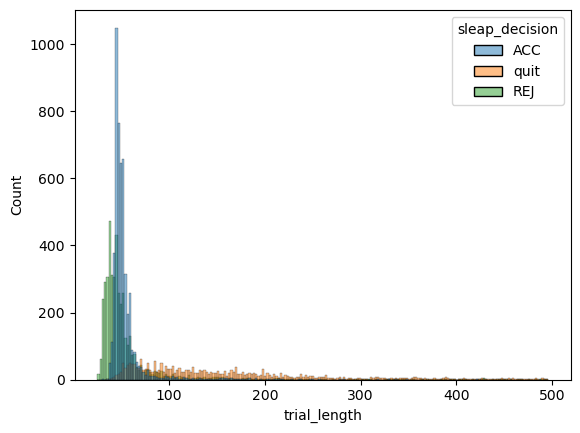

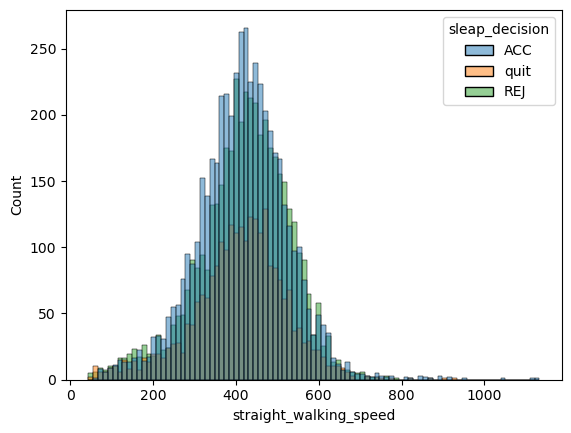

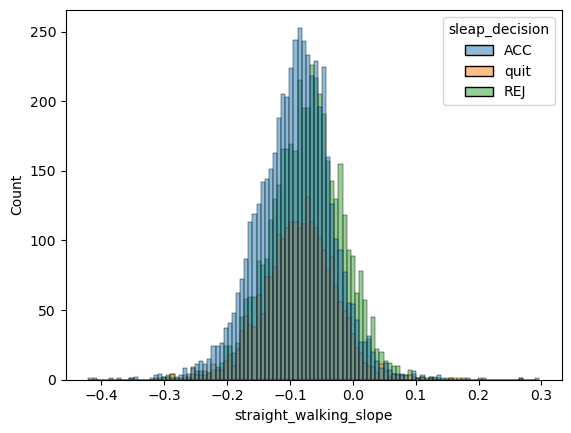

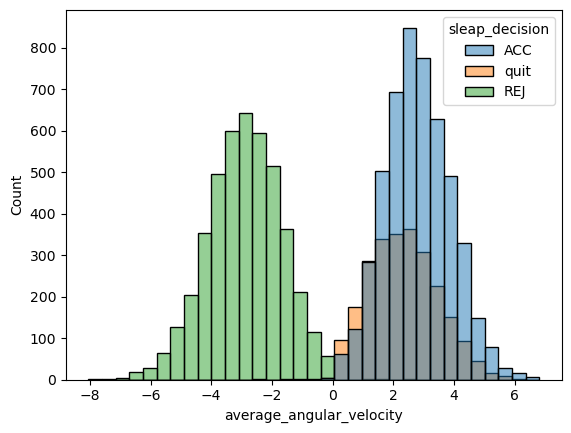

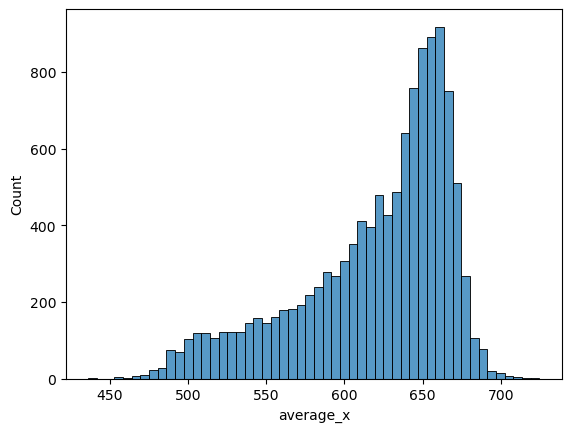

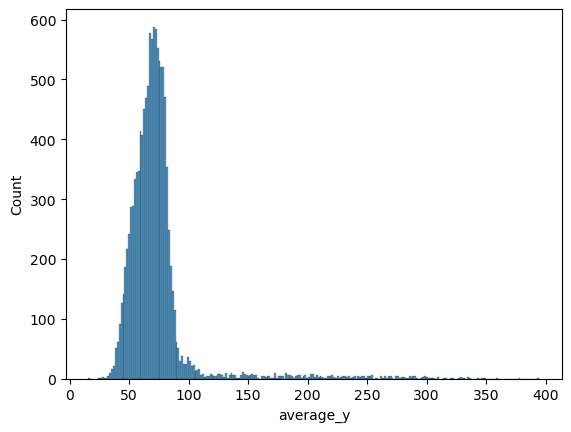

In [11]:
sns.histplot(data=trial_df, x='trial_length', hue='sleap_decision')
plt.show()
sns.histplot(data=trial_df, x='straight_walking_speed', hue='sleap_decision')
plt.show()
sns.histplot(data=trial_df, x='straight_walking_slope', hue='sleap_decision')
plt.show()
sns.histplot(data=trial_df, x='average_angular_velocity', hue='sleap_decision')
plt.show()
sns.histplot(data=trial_df, x='average_x')
plt.show()
sns.histplot(data=trial_df, x='average_y')
plt.show()


/var/folders/81/kqx_5t9n5vz_mq7d7n66fmdr0000gn/T/ipykernel_3848/1518197901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rej_trial_df['speed_bins'] = pd.cut(rej_trial_df['straight_walking_speed'], bins=num_bins)


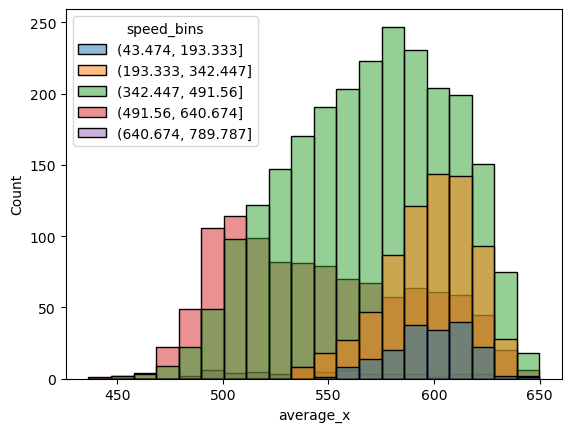

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the number of bins
num_bins = 5

# Create a new column 'speed_bins' with binned data
rej_trial_df['speed_bins'] = pd.cut(rej_trial_df['straight_walking_speed'], bins=num_bins)

# Plot the histogram with hue based on the binned data
sns.histplot(data=rej_trial_df, x='average_x', hue='speed_bins', bins=20)

# Show the plot
plt.show()


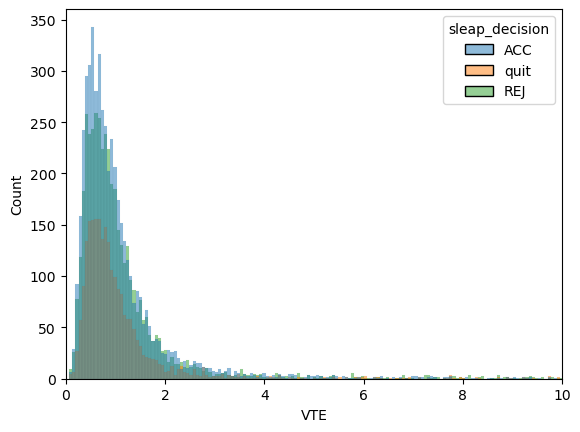

In [13]:
ax = sns.histplot(data=trial_df, x='VTE', hue='sleap_decision')
ax.set_xlim(0, 10)
plt.show()

2.8106407002054064
-2.9102240571849523
2.325542200408469


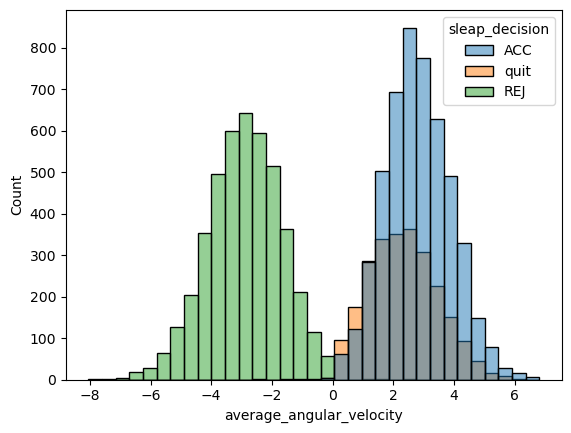

In [14]:
sns.histplot(data=trial_df, x='average_angular_velocity', hue='sleap_decision')
a = trial_df[trial_df['sleap_decision']=='ACC']['average_angular_velocity'].mean()
r = trial_df[trial_df['sleap_decision']=='REJ']['average_angular_velocity'].mean()
q = trial_df[trial_df['sleap_decision']=='quit']['average_angular_velocity'].mean()
print(a)
print(r)
print(q)

In [15]:
fast_trials = trial_df[trial_df['straight_walking_speed'] > 163]

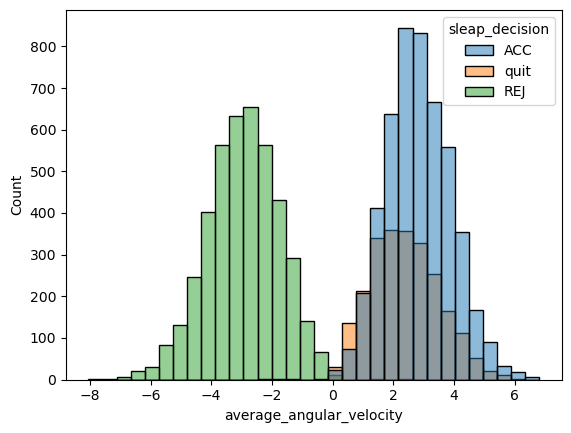

In [16]:
ax = sns.histplot(data=fast_trials, x='average_angular_velocity', hue='sleap_decision')
plt.show()

In [17]:
# trial_df.to_csv('/Users/yang/Documents/Wilbrecht_Lab/data/processed_tracks/trial_df.csv', index=False)